In [2]:
import copy
import time
import json
import requests
import numpy as np
import faiss
import open_clip
import glob
import torch
from PIL import Image
import os

import gensim.downloader as api

from flask_cors import CORS
from flask import Flask, request, jsonify
from utils.search_by_tag import search_tags, embed_tags
from utils.search_by_text import search_by_text

# Initialize Flask app
app = Flask(__name__, template_folder='templates')
CORS(app)

# Global variables to store the models and indexes
visual_encoder = None
text_encoder = None
frames_index = None
tag_index = None
visual_embeddings = None
tag_embeddings = None
tags_embedding = None 
first_request = True

def load_resources():
    print("Loading resource")
    global visual_encoder, text_encoder, frames_index, tag_index, visual_embeddings, tag_embeddings, tags_embedding

    frame_index_path = "dict/faiss_clipv2_cosine.bin"
    tag_index_path = "dict/frame_tag_cosine.bin"

    dataset_base_dir = 'data/keyframes/'
    npy_base_dir = 'data_extraction/CLIP_features/'
    keyframes_dir = 'dict/context_encoded/frame_tags_encoded'

    #### Load Model #####
    device = "cuda" if torch.cuda.is_available() else "cpu"
    visual_encoder, _, visual_preprocess = open_clip.create_model_and_transforms('ViT-L-14', device=device, pretrained='datacomp_xl_s13b_b90k')
    text_encoder = api.load("word2vec-google-news-300")

    frames_index = faiss.read_index(frame_index_path)
    tag_index = faiss.read_index(tag_index_path)

    # Key frames embedding
    # Initialize the mapping dictionary
    frame_to_feature_map = {}

    # Loop over each L0x directory
    for level_dir in sorted(os.listdir(dataset_base_dir)):
        if level_dir.startswith('Keyframes_'):
            level_id = level_dir.split('_')[1]  # Extract L0x
            
            # Loop over each video directory within the L0x directory
            for video_dir in sorted(os.listdir(os.path.join(dataset_base_dir, level_dir))):
                video_id = video_dir.split('_')[1]  # Extract V00y

                # Load the features from the corresponding npy file
                npy_file_path = os.path.join(npy_base_dir, level_id, f'{video_id}.npy')
                if os.path.exists(npy_file_path):
                    features = np.load(npy_file_path)
                else:
                    print(f"Warning: Missing npy file for {level_id}_{video_id}")
                    continue

                # Get the list of frames in the video directory
                frame_files = sorted(os.listdir(os.path.join(dataset_base_dir, level_dir, video_dir)))

                # Map each frame to its corresponding feature
                for i, frame_file in enumerate(frame_files):
                    if frame_file.endswith('.jpg'):
                        frame_index = os.path.splitext(frame_file)[0]
                        key = f"{level_id}_{video_id}_{frame_index}"
                        frame_to_feature_map[key] = features[i].reshape(1,-1)
    visual_embeddings = frame_to_feature_map          
                    
    # Tags embedding
    tag_embedding = dict()
    for part in sorted(os.listdir(keyframes_dir)):
        data_part = part.split('_')[-1]  # Extract data part like L01, L02
        if data_part[0] == 'L':
            data_part_path = f'{keyframes_dir}/{data_part}'
            video_dirs = sorted(os.listdir(data_part_path))

            # Iterate through each video directory
            for video_dir in video_dirs:
                if video_dir[0] != 'V':
                    continue
                vid_dir = video_dir[0:4]
                json_file_path = os.path.join(data_part_path, video_dir)

                # Open and read the JSON file
                with open(json_file_path, 'r') as json_file:
                    json_data = json.load(json_file)
                
                # Merge JSON data into the main dictionary
                for frame, tags in json_data.items():
                    new_key = f'{data_part}_{vid_dir}_{frame}'  # Create a new key
                    tag_embedding[new_key] = tags
    tags_embedding = tag_embedding
    tag_embeddings = {key: embed_tags(tags, text_encoder) for key, tags in tag_embedding.items()}

In [3]:
load_resources()

Loading resource


/home/nguyen/.local/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_locatio

In [20]:
print("text search")    
    
data ={
    'tag_search': "true",
    'prompt_search':"false",
    'tag_k':"2000",
    'prompt_k':"200",
    'tag_query':"snowman man red jacket snow",
    'prompt_query':"a man with red jacket and a snow man",   
    ### object color feature location with object ...
}
tag_search = data.get('tag_search').lower() == 'true' ## True/False
prompt_search = data.get('prompt_search').lower() == 'true' ## True/False
tag_k = int(data['tag_k']) # Number
prompt_k = int(data['prompt_k']) # Number
 
tag_query = str(data['tag_query']) # Str
prompt_query = str(data['prompt_query']) # Str

if tag_search:
    print("Searching by tag")
    tag_results, tag_indices = search_tags(tag_query, text_encoder, tag_index, tag_embeddings, tag_k)
    if prompt_search:
        print("Searching by prompt")
        visual_indices = []
        for key in tag_results:
            try:
                # Attempt to find the index of the key
                visual_index = list(visual_embeddings.keys()).index(key)
                visual_indices.append(visual_index)
            except ValueError:
                # Handle the case where the key is not found
                print(f"Warning: Key '{key}' not found in visual_embeddings")
                # Continue to the next key without appending
                continue
        prompt_results, prompt_indices = search_by_text(prompt_query, visual_encoder, frames_index, visual_embeddings, prompt_k, visual_indices)
    else:
        prompt_results, prompt_indices = tag_results, tag_indices
else:
    print("Searching by prompt")
    prompt_results, prompt_indices = search_by_text(prompt_query, visual_encoder, frames_index, visual_embeddings, prompt_k)

text search
Searching by tag


In [21]:
print(prompt_indices[:5])
print(prompt_results[:5])

[46899 46898 45076 45073 40582]
['L08_V001_140', 'L08_V001_139', 'L07_V023_250', 'L07_V023_247', 'L07_V002_187']


In [22]:
vid = 'L08_V001_140'
print(prompt_results.index(vid))

0


In [23]:
print(tags_embedding[vid])

['blanket', 'coat', 'jacket', 'man', 'red', 'snow', 'snowman', 'stand', 'wear']


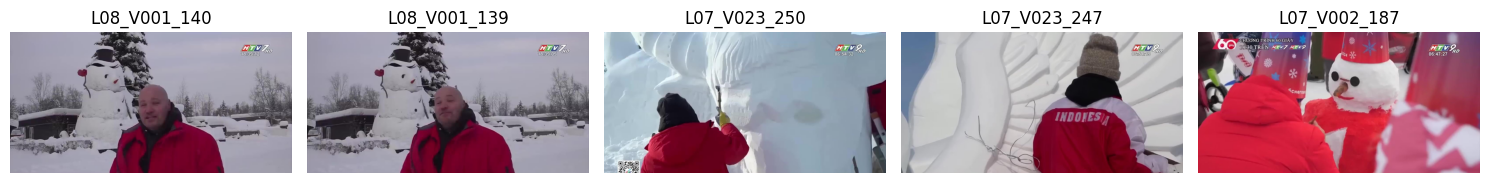

In [24]:
import matplotlib.pyplot as plt
from PIL import Image

# Base directory
base_dir = 'data/keyframes'

# Create a figure to plot images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Process each key
for ax, key in zip(axes, prompt_results[:5]):
    # Split the key to extract components
    parts = key.split('_')
    level = parts[0]
    video = parts[1]
    frame = parts[2]
    
    # Construct the path
    path = f"{base_dir}/Keyframes_{level}/{level}_{video}/{frame}.jpg"
    
    # Load and plot the image
    img = Image.open(path)
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(key)  # Optionally, set the title to the key

plt.tight_layout()
plt.show()
